# Variational Autoencoder Training on MNIST Images

In [1]:
# Load all relevant modules
import os
import time as timer

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import numpy as np
from IPython import display
from skimage.util import random_noise

from torchvision import datasets
import torchvision.transforms as T
import torchvision.utils as vutils
from torchviz import make_dot

import res.viz_utils as vu
from res.plot_lib import set_default

set_default()

In [2]:
# Define constants
DATA_DIR = "data"
MODEL_DIR = "models"
BATCH_SIZE = 64
NUM_EPOCH = 30
DATASET = 'mnist'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

### Load Training and Test Dataset

In [3]:
# Transform to (-1, 1) 
img_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

if DATASET == 'mnist':
    dataset_func = datasets.MNIST
elif DATASET == 'fmnist':
    dataset_func = datasets.FashionMNIST

# Load train
train_data = dataset_func(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=img_transform,
)

# Load test
test_data = dataset_func(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=img_transform,
)

In [4]:
# Create data loader
train_loader = DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE,
)

test_loader = DataLoader(
    test_data,
    shuffle=False,
    batch_size=BATCH_SIZE,
)

In [5]:
# Define model architecture and loss function
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        self.hidden_size = hidden_size

        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size ** 2),
            nn.Tanh(),
            nn.Linear(hidden_size ** 2, hidden_size * 2),
        )

        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, hidden_size ** 2),
            nn.Tanh(),
            nn.Linear(hidden_size ** 2, input_size),
            nn.Tanh(),
        )
    
    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_()
            return eps.mul_(std).add_(mu)
        else:
            return mu
    
    def encode(self, x):
        mu_logvar = self.encoder(x)
        mu_logvar = mu_logvar.view(-1, 2, self.hidden_size)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return z, mu, logvar
    
    def decode(self, z):
        return self.decoder(z)
        
    def forward(self, x):
        z, mu, logvar = self.encode(x)
        xr = self.decode(z)
        return xr, mu, logvar
    
def vae_loss(x_hat, x, mu, logvar, beta=1):
    rec_loss = nn.functional.mse_loss(x_hat, x, reduction="sum")
    kl_loss = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)

    vae_loss = rec_loss + beta * kl_loss
    return vae_loss, rec_loss, kl_loss

In [6]:
[n, dx1, dx2] = train_data.data.size()
input_size = dx1 * dx2
hidden_size = 20
beta =  1
fixed_noise = torch.randn(64, hidden_size, device=DEVICE)

model = VariationalAutoencoder(input_size, hidden_size).to(DEVICE)

criterion = vae_loss
optimizer = optim.Adam(
    lr=1e-3,
    params=model.parameters()
)


In [7]:
print(model)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Tanh()
    (2): Linear(in_features=400, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=400, bias=True)
    (1): Tanh()
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Tanh()
  )
)


### Train Model

The new directory models/vae_samples_mnist has been created
Epoch [1/30], vae_loss: 2606.6755, rec_loss: 1662.9363, kl_loss: 943.7392, elapsed_t:  7.53 secs
 ---- Model models/vae_mnist_z20_ep30.pth stored!
img_np : 0.0 1.0
img_np : 0.0 1.0
Epoch [2/30], vae_loss: 2696.1255, rec_loss: 1751.8198, kl_loss: 944.3057, elapsed_t:  7.36 secs
 ---- Model models/vae_mnist_z20_ep30.pth stored!
img_np : 0.0 1.0
img_np : 0.0 1.0
Epoch [3/30], vae_loss: 2357.8757, rec_loss: 1438.8076, kl_loss: 919.0681, elapsed_t:  7.37 secs
 ---- Model models/vae_mnist_z20_ep30.pth stored!
img_np : 0.0 1.0
img_np : 0.0 0.99999994
Epoch [4/30], vae_loss: 2550.3411, rec_loss: 1612.3771, kl_loss: 937.9641, elapsed_t:  6.82 secs
 ---- Model models/vae_mnist_z20_ep30.pth stored!
img_np : 0.0 1.0
img_np : 0.0 1.0
Epoch [5/30], vae_loss: 2416.6541, rec_loss: 1507.2520, kl_loss: 909.4022, elapsed_t:  6.84 secs
 ---- Model models/vae_mnist_z20_ep30.pth stored!
img_np : 0.0 1.0
img_np : 0.0 1.0
Epoch [6/30], vae_loss: 2295

/Users/mghifary/Work/govtech/codes/AI/IF5281/res/viz_utils.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)


Epoch [12/30], vae_loss: 2115.3481, rec_loss: 1205.3461, kl_loss: 910.0021, elapsed_t:  6.81 secs
 ---- Model models/vae_mnist_z20_ep30.pth stored!
img_np : 0.0 1.0
img_np : 0.0 1.0
Epoch [13/30], vae_loss: 2351.6694, rec_loss: 1386.3905, kl_loss: 965.2790, elapsed_t:  6.71 secs
 ---- Model models/vae_mnist_z20_ep30.pth stored!
img_np : 0.0 1.0
img_np : 0.0 1.0
Epoch [14/30], vae_loss: 2411.7202, rec_loss: 1482.1252, kl_loss: 929.5949, elapsed_t:  6.77 secs
 ---- Model models/vae_mnist_z20_ep30.pth stored!
img_np : 0.0 1.0
img_np : 0.0 1.0
Epoch [15/30], vae_loss: 2026.6423, rec_loss: 1121.4362, kl_loss: 905.2062, elapsed_t:  7.30 secs
 ---- Model models/vae_mnist_z20_ep30.pth stored!
img_np : 0.0 1.0
img_np : 0.0 1.0
Epoch [16/30], vae_loss: 2219.0776, rec_loss: 1267.4961, kl_loss: 951.5817, elapsed_t:  7.51 secs
 ---- Model models/vae_mnist_z20_ep30.pth stored!
img_np : 0.0 1.0
img_np : 0.0 1.0
Epoch [17/30], vae_loss: 2191.9714, rec_loss: 1255.1858, kl_loss: 936.7856, elapsed_t:  7.

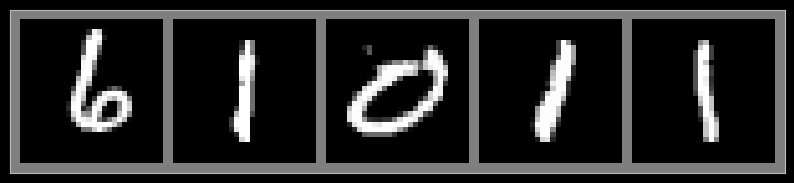

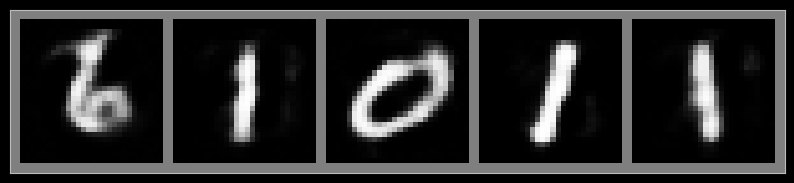

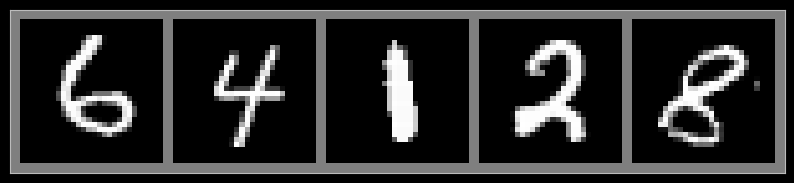

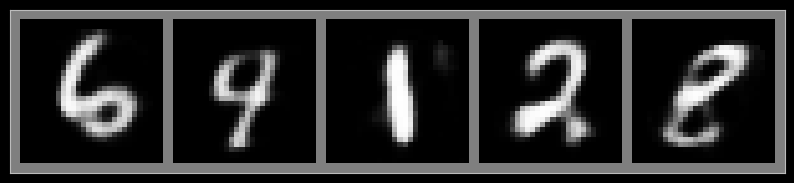

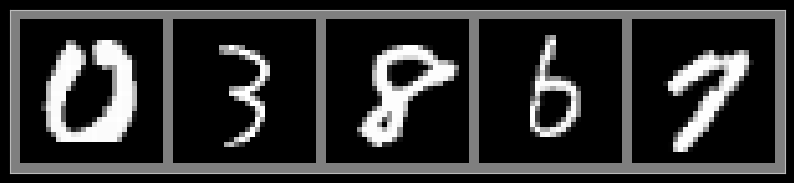

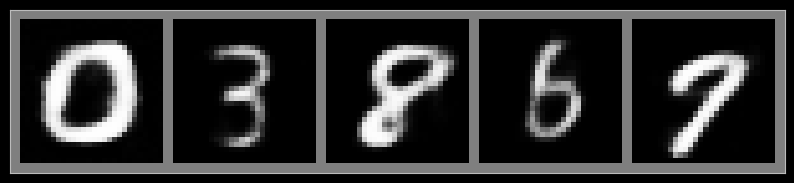

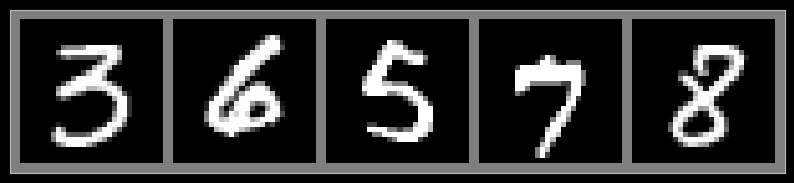

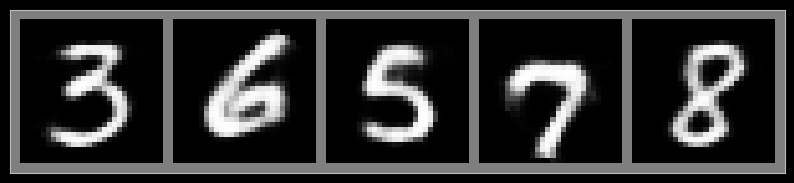

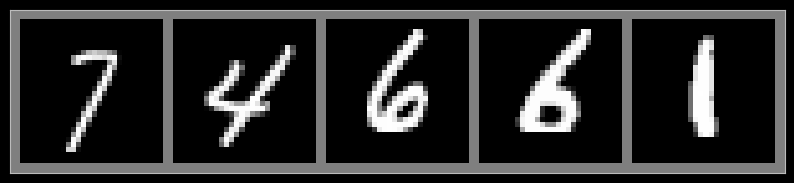

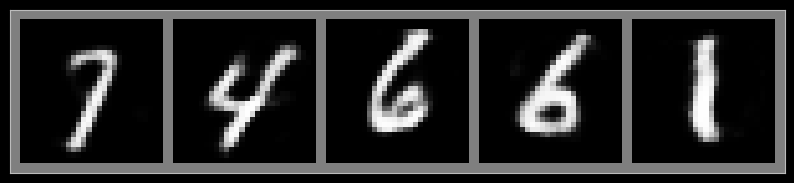

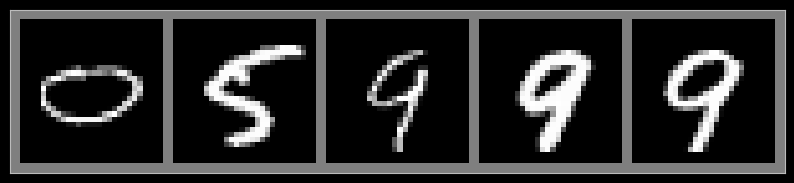

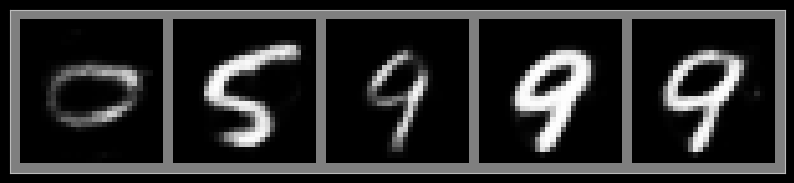

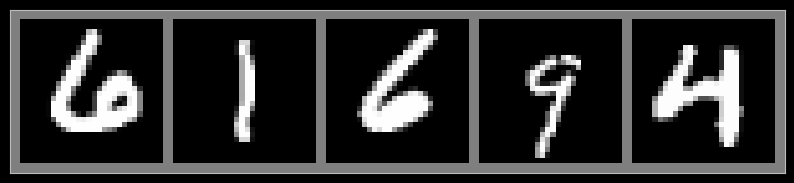

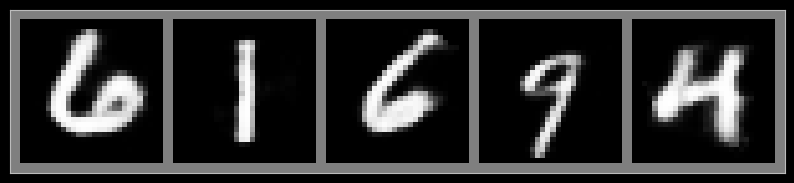

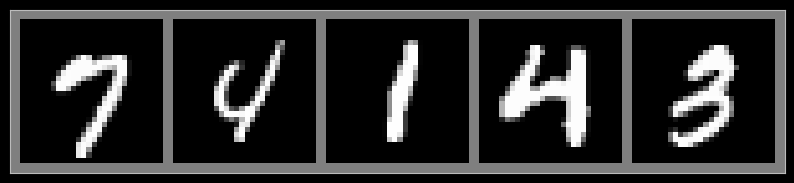

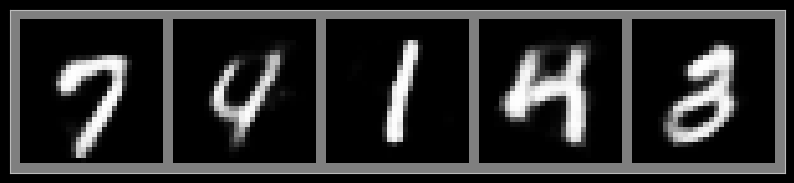

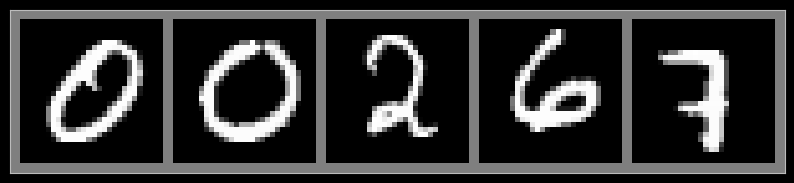

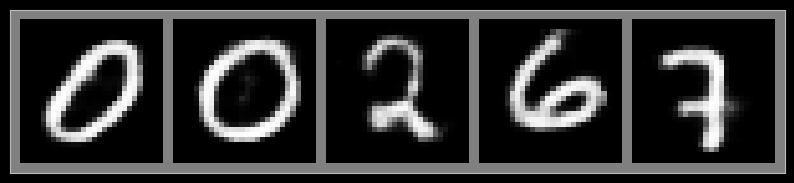

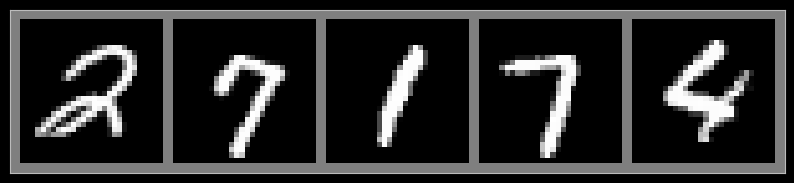

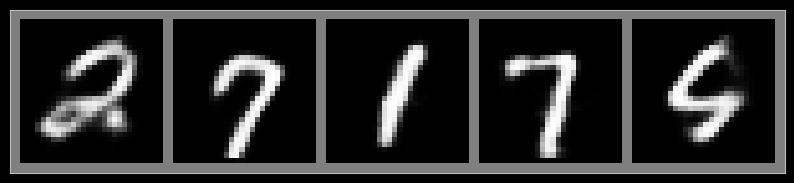

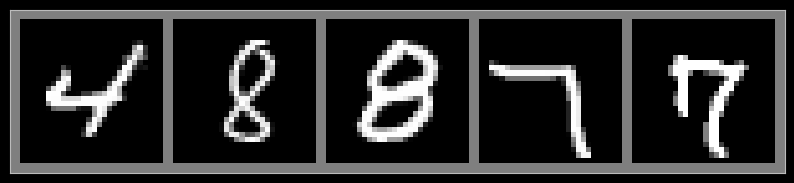

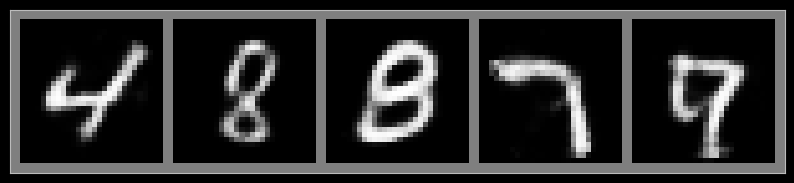

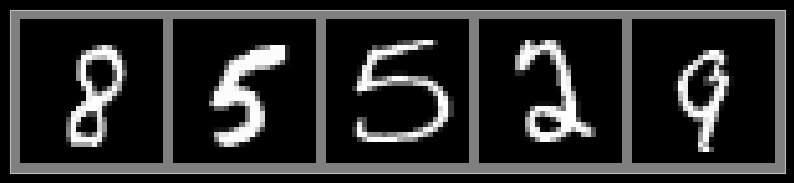

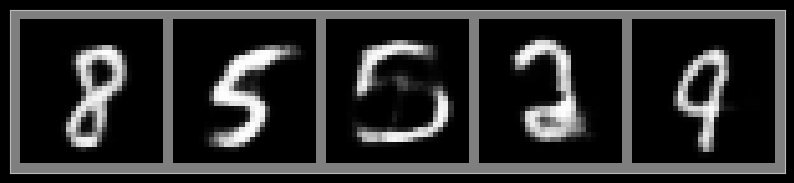

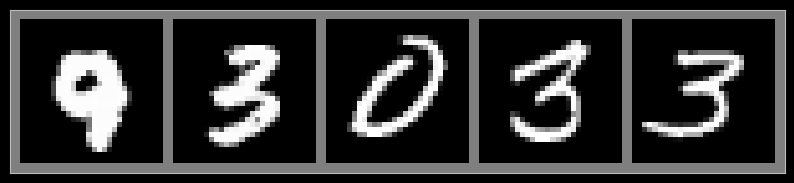

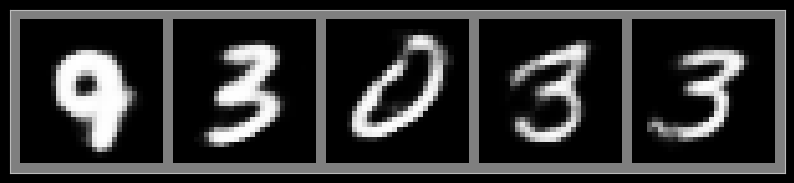

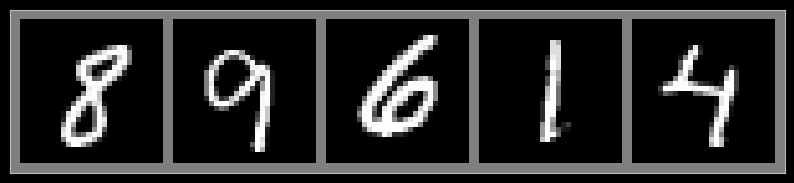

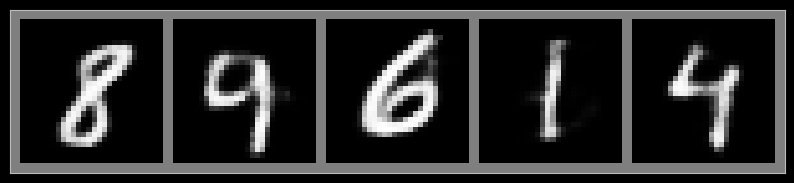

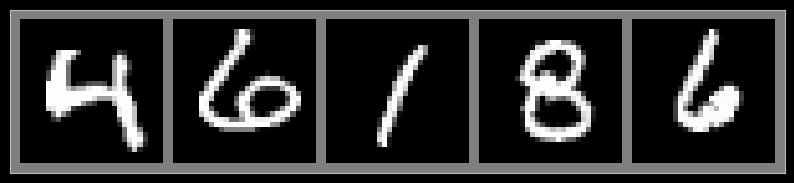

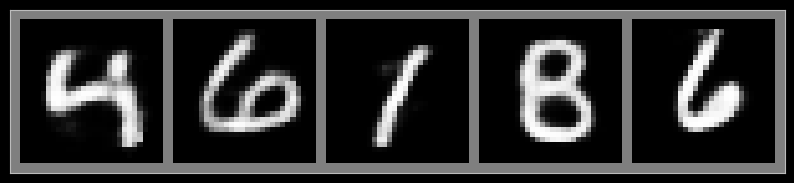

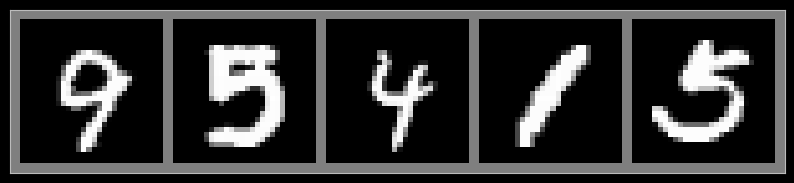

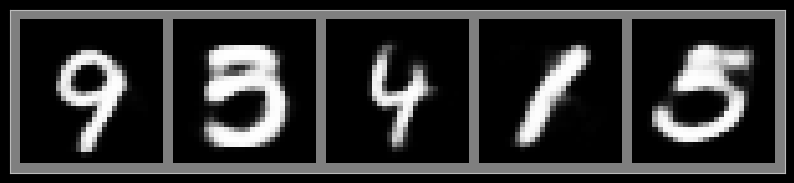

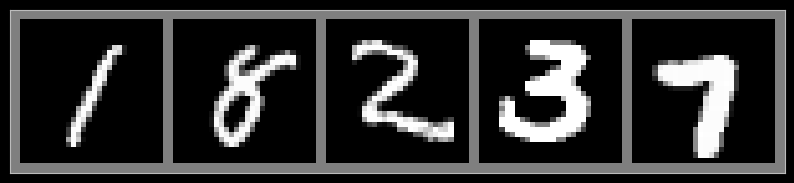

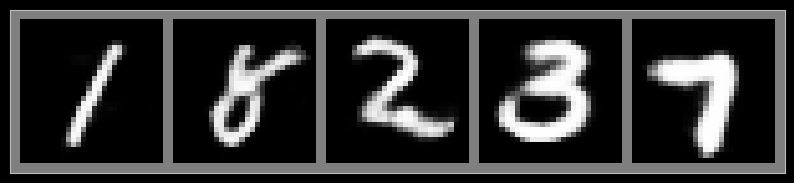

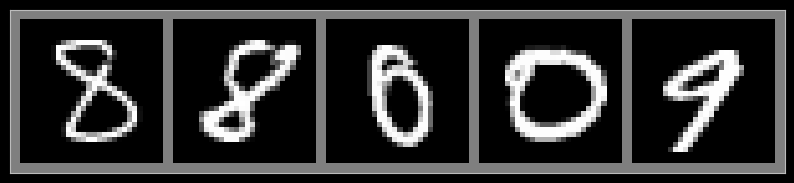

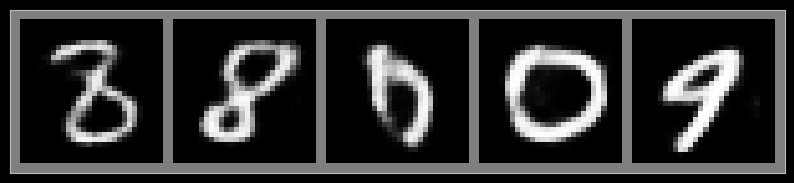

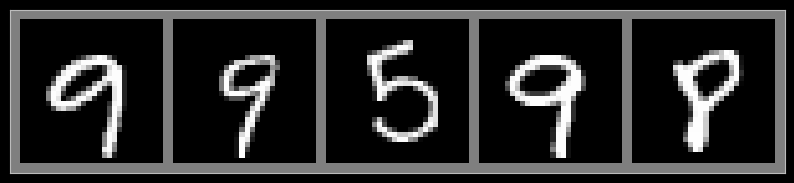

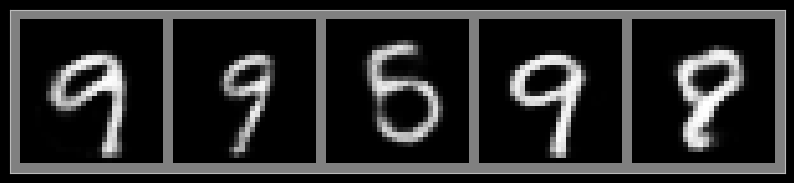

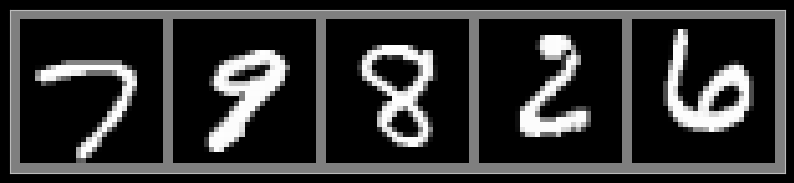

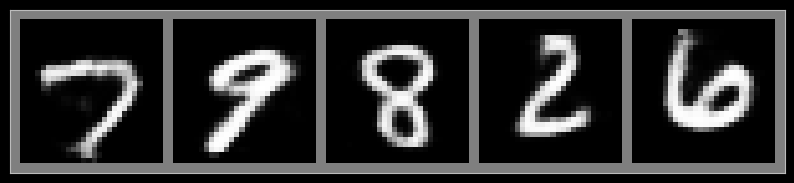

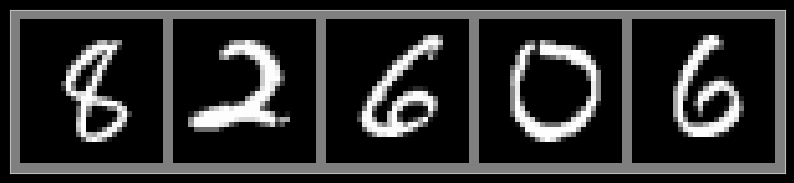

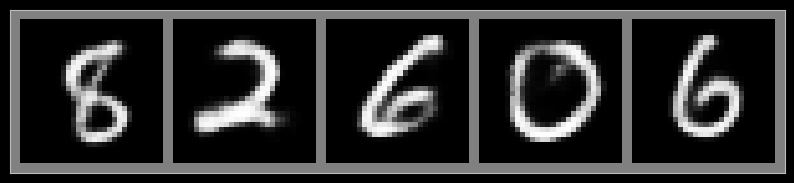

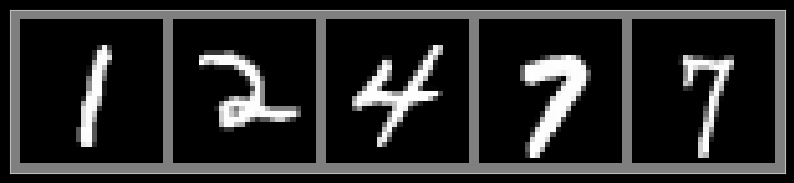

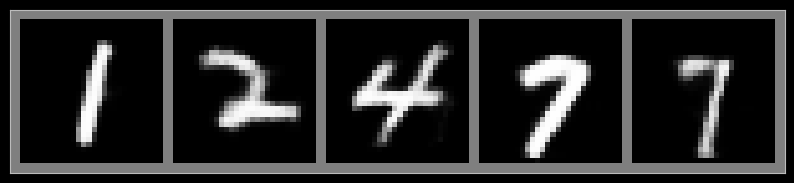

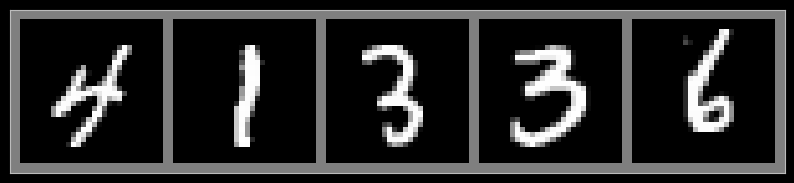

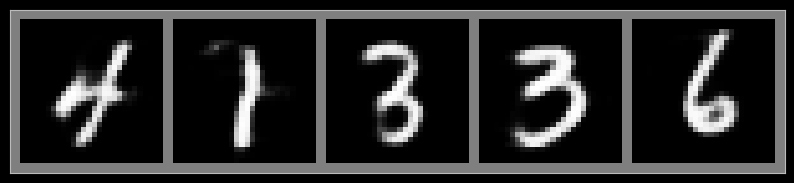

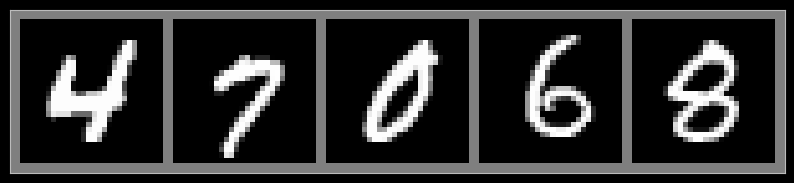

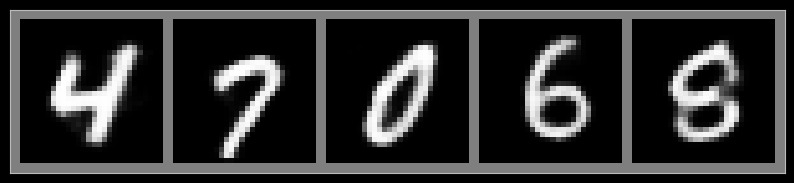

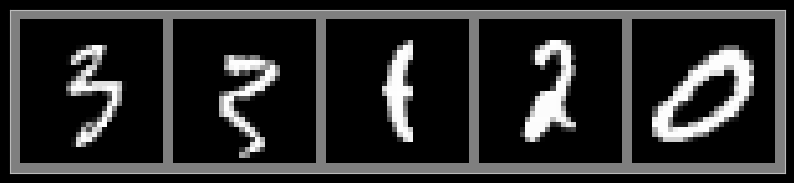

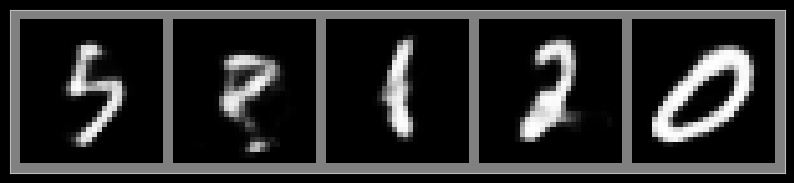

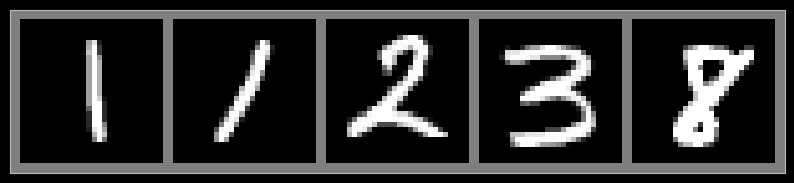

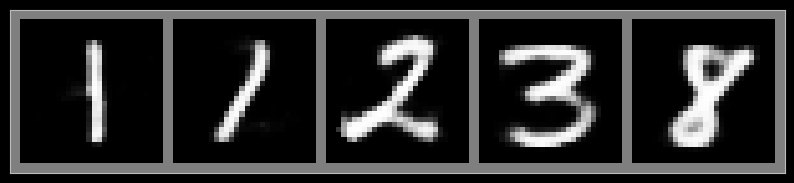

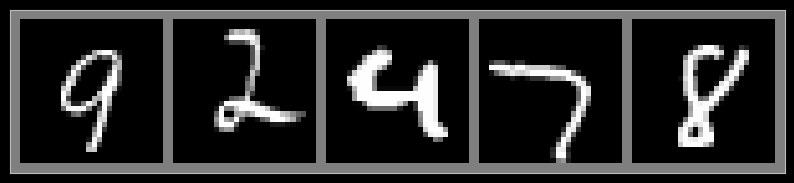

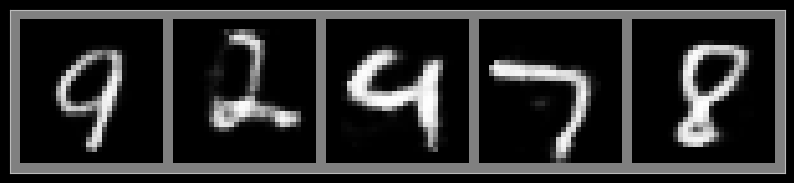

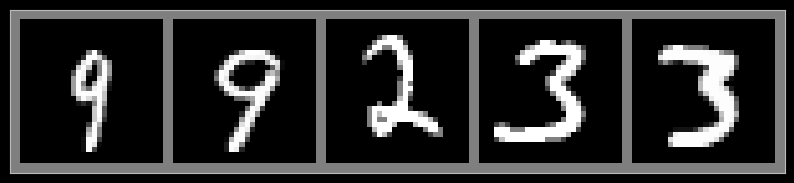

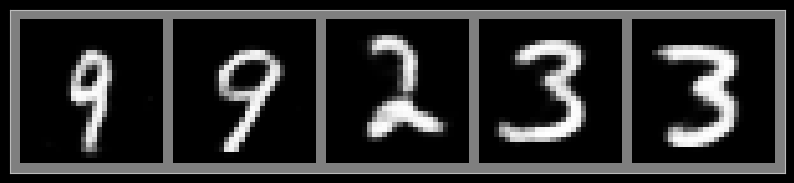

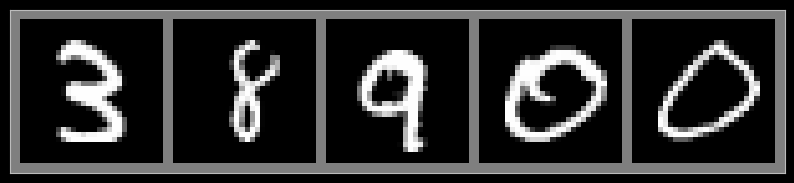

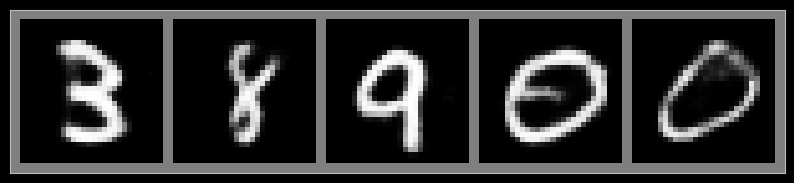

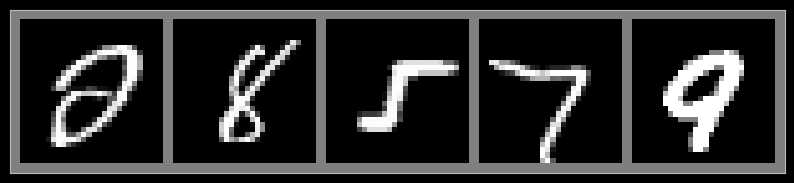

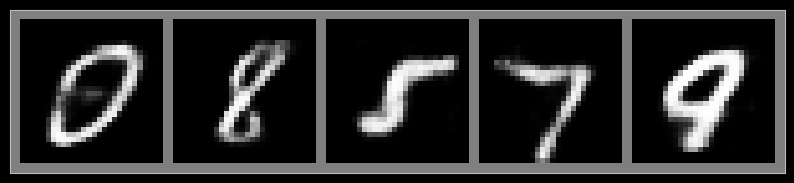

In [8]:
mname = "vae" 
model_path = os.path.join(MODEL_DIR, f"{mname}_{DATASET}_z{hidden_size}_ep{NUM_EPOCH}.pth")

sample_dir = os.path.join(MODEL_DIR, f"{mname}_samples_{DATASET}")

# create SAMPLE_DIR if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
    print(f'The new directory {sample_dir} has been created')

model.train()

for epoch in range(NUM_EPOCH):
    start_t = timer.time()
    for batch_idx, (X, _) in enumerate(train_loader):
        
        # Feed forward
        X = X.view(-1, input_size).to(DEVICE)
        
        Xr, Mu, Logvar = model(X)


        # Compute loss
        vae_loss, rec_loss, kl_loss = criterion(Xr, X, Mu, Logvar, beta=beta)

        # Backprop
        optimizer.zero_grad()
        vae_loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            
            with torch.no_grad():
                Rec = model.decode(fixed_noise)
            
            Rec = Rec.view(-1, 1, dx1, dx2)
            # vutils.save_image(Input, f'{sample_dir}/original.png', normalize=True)
            vutils.save_image(Rec, f'{sample_dir}/reconstruction-{epoch+1}_batch-{batch_idx}.png', normalize=True)

        
    # end for
    elapsed_t = timer.time() - start_t

    print(f'Epoch [{epoch+1}/{NUM_EPOCH}], vae_loss: {vae_loss.item():.4f}, rec_loss: {rec_loss.item():.4f}, kl_loss: {kl_loss.item():.4f}, elapsed_t: {elapsed_t: 0.2f} secs')

    # Save model
    torch.save(model.state_dict(), model_path)
    print(f" ---- Model {model_path} stored!")

    # Display input images and their reconstructions
    Input = X.view(-1, 1, dx1, dx2).detach().cpu().numpy()
    Rec = Xr.view(-1, 1, dx1, dx2).detach().cpu().numpy()
    grid_x = vu.set_grid(Input, num_cells=5)
    vu.show(grid_x)

    grid_xr = vu.set_grid(Rec, num_cells=5)
    vu.show(grid_xr)
# end for